In [6]:
import os
import time
from typing import Tuple
from pathlib import Path

import pandas as pd
import numpy as np

import html2text
import tqdm
import pickle
import matplotlib.pyplot as plt


import html2text

# Load movies dataset

In [7]:
DATA_PATH = os.path.expandvars("$MOVIES_DATA/origin")

In [8]:
os.listdir(DATA_PATH)

['movies_subtitles.csv', 'movies_subtitles_text.csv', 'movies_meta.csv']

In [27]:
subs = pd.read_csv(Path(DATA_PATH, 'movies_subtitles.csv'))
subs.dropna(inplace=True)
subs.drop_duplicates(["imdb_id", "start_time", "end_time", "text"], inplace=True)
subs = subs.sort_values(["imdb_id", "start_time", "end_time"]).reset_index(drop=True)
subs["text"] = subs["text"].apply(html2text.html2text).str.strip().str.replace('\n', ' ')

In [29]:
subs.to_csv(Path(DATA_PATH, 'movies_subtitles_text.csv'))

In [195]:
subs = pd.read_csv(Path(DATA_PATH, 'movies_subtitles_text.csv'))

In [197]:
subs[subs["imdb_id"]=='tt0114709']

,Unnamed: 0,start_time,end_time,text,imdb_id
1778361,1778361,58.559,61.602,"BOY: All right, everyone! This... is a stick-up!",tt0114709
1778362,1778362,61.687,63.354,Don't anybody move!,tt0114709
1778363,1778363,64.398,66.482,"Now, empty that safe!",tt0114709
1778364,1778364,68.318,71.612,"Ooh-hoo-hoo! Money, money, money! (KISSING)",tt0114709
1778365,1778365,71.697,74.031,"Stop it! Stop it, you mean, old potato!",tt0114709
...,...,...,...,...,...
1779742,1779742,4722.509,4725.595,♪ Our friendship will never die,tt0114709
1779743,1779743,4727.139,4731.935,♪ You're gonna see it's our destiny,tt0114709
1779744,1779744,4732.019,4735.980,♪ You've got a friend in me,tt0114709
1779745,1779745,4736.065,4738.650,♪ You've got a friend in me,tt0114709


# Analysis for deltas between  lines, line duration, length, and speed for all movies together

In [198]:
def _clean_times(s: np.array, e: np.array) -> Tuple[np.array, np.array, np.array]:
    """
    s: start time
    e: end time
    d: duration
    """
    d = e - s
    e = np.where(d<0, 1, 0) * s + np.where(d>=0, 1, 0) * e
    d = e - s
    return s, e, d
 
def prepare_times(subs: pd.DataFrame):
    _, e, d = _clean_times(subs["start_time"].values, subs["end_time"].values)
    subs["end_time"]
    subs["duration"] = d
  


In [199]:
prepare_times(subs)

subs["delta"] = 0  
for i, group in tqdm.tqdm(subs.groupby("imdb_id")):
    subs.loc[group.index[1:], "delta"] = subs.loc[group.index[1:], "start_time"].values - subs.loc[group.index[:-1],"end_time"].values

subs["text_len"] = subs["text"].str.len()
subs["text_speed"] = np.divide(subs["text_len"].values,
                               subs["duration"].values,
                               out=np.zeros_like(subs["text_len"].values), 
                               where=subs["duration"].values!=0)

100%|██████████████████████████████████████| 4664/4664 [00:04<00:00, 990.52it/s]


In [200]:
subs["duration"].describe()

count    5.201231e+06
mean     2.507535e+00
std      1.893332e+01
min      0.000000e+00
25%      1.706000e+00
50%      2.298000e+00
75%      3.084000e+00
max      4.248300e+04
Name: duration, dtype: float64

In [201]:
subs["duration"].quantile(0.95), subs["duration"].quantile(0.975), subs["duration"].quantile(0.999)

(4.493999999999687, 5.003999999998996, 8.208999999999833)

In [202]:
subs["text_len"].describe()

count    5.201212e+06
mean     3.384919e+01
std      1.799985e+01
min      1.000000e+00
25%      2.000000e+01
50%      3.200000e+01
75%      4.600000e+01
max      4.770000e+02
Name: text_len, dtype: float64

In [203]:
subs["text_len"].quantile(0.05), subs["text_len"].quantile(0.95),  subs["text_len"].quantile(0.999)

(7.0, 66.0, 93.0)

In [204]:
subs["text_speed"].describe()

count    5.201212e+06
mean     1.442413e+01
std      9.731904e+01
min      0.000000e+00
25%      9.690817e+00
50%      1.357143e+01
75%      1.755379e+01
max      8.350000e+04
Name: text_speed, dtype: float64

In [205]:
subs["text_speed"].quantile(0.01), subs["text_speed"].quantile(0.05), subs["text_speed"].quantile(0.95),  subs["text_speed"].quantile(0.999)

(2.4691358024695793, 4.552352048558322, 24.182076813656636, 80.64516128986358)

In [210]:
subs[subs["duration"]>subs["duration"].quantile(0.9999)]

,Unnamed: 0,start_time,end_time,text,imdb_id,duration,delta,text_len,text_speed
19883,19883,6301.240,6321.993,"""The Word that wings joyfully throughout the u...",tt0016847,20.753,3.129,183.0,8.818002
24513,24513,5134.000,5734.000,"Auto translated by "" **Free SRT-File Translato...",tt0019130,600.000,0.686,111.0,0.185000
61591,61591,9949.137,10190.137,© anoXmous @ https://thepiratebay.se/user/Zen...,tt0023427,241.000,92.082,50.0,0.207469
75584,75584,65.090,120.000,"CAPADOCIA, 55 AD Subtitles Encoded by Loya Nao...",tt0024453,54.910,0.000,65.0,1.183755
76192,76192,5400.000,5520.000,"Subtitle encoded by Loya Naorem, Manipur, India",tt0024453,120.000,47.360,47.0,0.391667
...,...,...,...,...,...,...,...,...,...
5060697,5060697,4643.280,4801.314,Batman_Vs_Robin Re-Sync & Edit Tharindu_Lakmal...,tt4324274,158.034,0.001,56.0,0.354354
5060710,5060710,36.000,66.000,filmeuy.com Free Watch Online & Download Movies,tt4329098,30.000,0.229,47.0,1.566667
5072944,5072944,3.303,30.229,[♪♪♪],tt4460176,26.926,0.000,5.0,0.185694
5115362,5115362,5095.037,5121.948,We help you to be MODERN Fashion Style Portrai...,tt4799050,26.911,6.343,76.0,2.824124


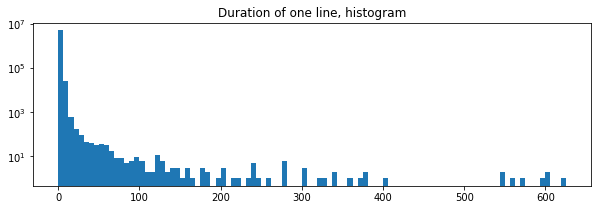

In [96]:
plt.figure(figsize=(10,3))
plt.hist(subs[subs["duration"]< 10**3]["duration"], bins = 100, log=True)
plt.title("Duration of one line, histogram")
plt.show()

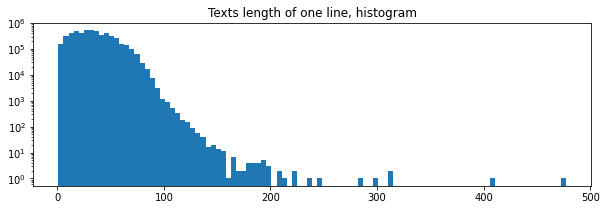

In [97]:
plt.figure(figsize=(10,3))
plt.hist(subs["text_len"], bins = 100, log=True)
plt.title("Texts length of one line, histogram")
plt.show()

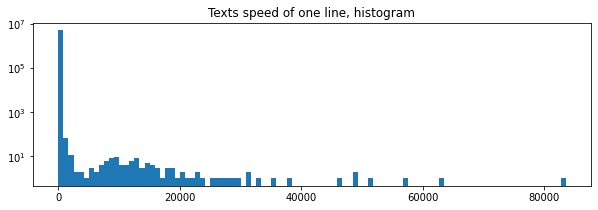

In [98]:
plt.figure(figsize=(10,3))
plt.hist(subs["text_speed"], bins = 100, log=True)
plt.title("Texts speed of one line, histogram")
plt.show()

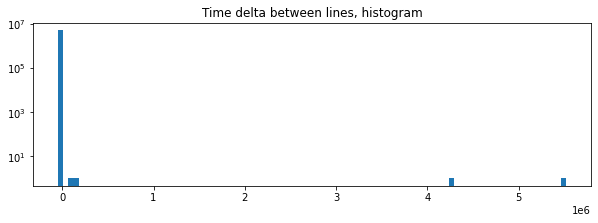

In [99]:
plt.figure(figsize=(10,3))
plt.hist(subs["delta"], bins = 100, log=True)
plt.title("Time delta between lines, histogram")
plt.show()

# Analysis for one movie

In [211]:
full_subs = subs.copy()

In [242]:
subs = full_subs[full_subs["imdb_id"]=='tt0024453']

In [243]:
subs.reset_index(inplace=True, drop=True)

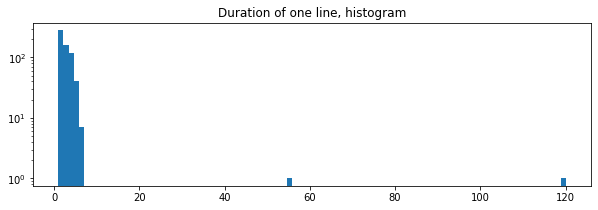

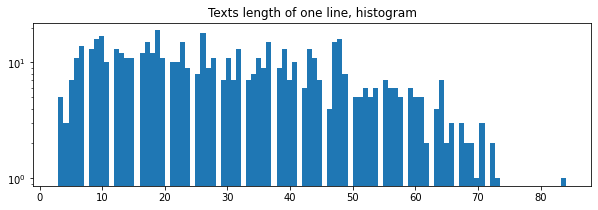

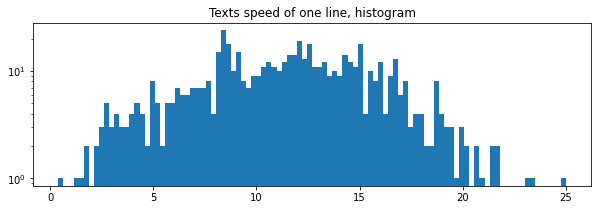

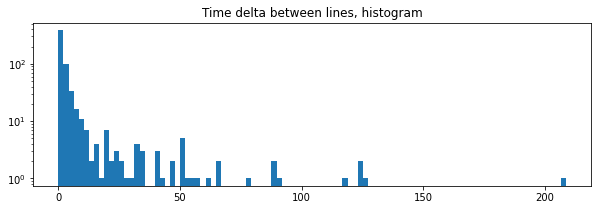

In [244]:
plt.figure(figsize=(10,3))
plt.hist(subs[subs["duration"]< 10**3]["duration"], bins = 100, log=True)
plt.title("Duration of one line, histogram")
plt.show()
plt.figure(figsize=(10,3))
plt.hist(subs["text_len"], bins = 100, log=True)
plt.title("Texts length of one line, histogram")
plt.show()
plt.figure(figsize=(10,3))
plt.hist(subs["text_speed"], bins = 100, log=True)
plt.title("Texts speed of one line, histogram")
plt.show()
plt.figure(figsize=(10,3))
plt.hist(subs["delta"], bins = 100, log=True)
plt.title("Time delta between lines, histogram")
plt.show()

In [245]:
subs["duration"].quantile(0.95), subs["duration"].quantile(0.975), subs["duration"].quantile(0.999)

(4.961400000000049, 5.403799999999864, 80.42528000000343)

In [246]:
subs["text_len"].quantile(0.05), subs["text_len"].quantile(0.95),  subs["text_len"].quantile(0.999)

(7.0, 62.60000000000002, 77.31200000000058)

In [247]:
subs["text_speed"].quantile(0.01), subs["text_speed"].quantile(0.05), subs["text_speed"].quantile(0.95),  subs["text_speed"].quantile(0.999)

(2.236070493484993, 3.972881355932228, 18.69552669552656, 24.00869565217266)

In [248]:
subs["delta"].quantile(0.95), subs["delta"].quantile(0.975), subs["delta"].quantile(0.999)

(32.958600000000075, 51.99519999999999, 158.1234480000044)

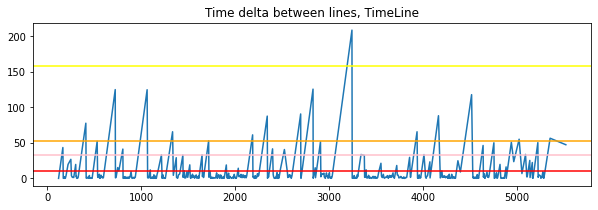

In [249]:
plt.figure(figsize=(10,3))
plt.plot(subs["end_time"], subs["delta"], )
plt.axhline(subs["delta"].quantile(0.90), c='red')
plt.axhline(subs["delta"].quantile(0.95), c='pink')
plt.axhline(subs["delta"].quantile(0.975), c='orange')
plt.axhline(subs["delta"].quantile(0.999), c='yellow')
plt.title("Time delta between lines, TimeLine")
plt.show()

In [250]:
sum(subs["delta"] > subs["delta"].quantile(0.95))

31

# Cut movie into scenes

In [251]:
from dataclasses import dataclass

@dataclass
class Scene:
    text: str
    start: float
    end: float
    n_lines: int

In [252]:
quantile_95 = subs["delta"].quantile(0.95)
scenes = []
scene_start = 0
scene = ''
for i, (text, delta) in enumerate(subs[['text', 'delta']].values):
    if delta > quantile_95:
        scenes.append(Scene(text=scene.strip(),
                            start=subs.at[scene_start, 'start_time'],
                            end=subs.at[i-1, 'start_time'],
                            n_lines=i-scene_start)
                     )
        scene_start = i
        scene = ''
    scene+=text
    scene+=' '
scenes.append(Scene(text=scene.strip(),
                            start=subs.at[scene_start, 'start_time'],
                            end=subs.at[i, 'start_time'],
                            n_lines=i-scene_start)
                     )


In [255]:
pd.DataFrame(scenes)

,text,start,end,n_lines
0,"CAPADOCIA, 55 AD Subtitles Encoded by Loya Nao...",65.090,65.090,1
1,1209 DC NOW Christianity dominated Europe. BY ...,163.420,327.410,24
2,"While we had no visitors, brother Geraldus. Es...",406.829,474.689,18
3,Brother Ciarán ... Cathal... Street... y Diarm...,529.379,591.009,15
4,"Come on. Come on. Quiet. Chill chill. Rua, Cat...",721.940,760.049,6
5,They are afraid of it. Even before the lightni...,802.590,935.350,35
6,What country. \- It rains as the second flood....,1061.380,1178.829,25
7,Fighting on the border. Make sure to eat at le...,1213.000,1265.680,14
8,Geraldus. All I ask is a little faith. It is s...,1332.380,1609.289,40
9,Fournier. Fournier. My father has awakened? I ...,1646.400,1661.880,4


In [254]:
for s in scenes:
    print(s.start, s.end, s.n_lines)
    print(s.text)
    print()

65.09 65.09 1
CAPADOCIA, 55 AD Subtitles Encoded by Loya Naorem, Manipur, India

163.42 327.41 24
1209 DC NOW Christianity dominated Europe. BY FAITH, they are launched crusades to recapture Jerusalem. IRELAND IS FAR FROM HOLY LAND. NORMAN INVADERS loyalists King John of England. FIGHT TO CONQUER THE ISLAND IN GAELIC. A DISTANT MONASTERY PROTEGE an ancient relic. KILMANNAN WEST COAST OF IRELAND. Dammit! What do you think he was thinking the first man who ate this? Brother Cathal said they have no soul ... Animals on earth to clothe and feed. Every creature that does not serve us is our enemy. How would you know the man who serves creature? Was it funny? Desperate? Did God put the idea in your head? Gentlemen. Gentlemen. \- Gentlemen! - How many? \- Three. - Did you see the colors? \- Do you know what clan they are? - Abad, are warriors with them. \- The relic was moved? - Of course not, Abad. Then we will continue with our duties as usual. But Abad .... You've already heard.

406.829 4